# Feature-based Augmented Reality App

A feature-based augmented reality app made with Python and OpenCV. Uses feature matching to calculate camera pose, homography, and render the 3D object.

# Imports and setup

In [67]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from ar_app.objloader_simple import *

# Load Marker and Source images

Marker reference image:

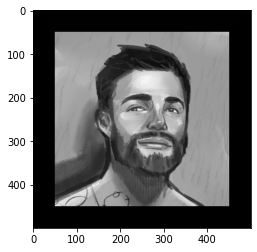

In [68]:
ref_image = cv2.imread('./img/me-marker.png', 0)

plt.imshow(ref_image, cmap='gray')
plt.show()

Source image that contains the marker:

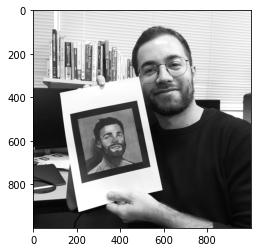

In [69]:
# src_image = cv2.imread('./img/src_hiro-front.png', 0)
# src_image = cv2.imread('./img/src_hiro-diagonal.png', 0)
# src_image = cv2.imread('./img/src_hiro-webcam.png', 0)
src_image = cv2.imread('./img/src_me-small.png', 0)

plt.imshow(src_image, cmap='gray')
plt.show()

Images are converted to gray scale for better processing.

# Feature detection

We'll use features and their description to identify markers. As such, we have to extract them from both the reference and the source image.

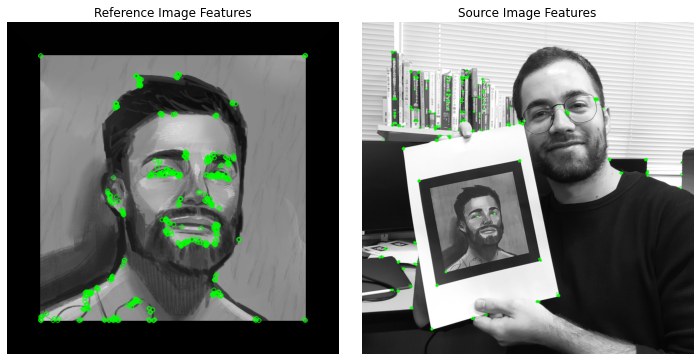

In [77]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
ref_image_pts = orb.detect(ref_image, None)
src_image_pts = orb.detect(src_image, None)

# compute the descriptors with ORB
ref_image_pts, ref_image_dsc = orb.compute(ref_image, ref_image_pts)
src_image_pts, src_image_dsc = orb.compute(src_image, src_image_pts)

ref_image_features = cv2.drawKeypoints(ref_image, ref_image_pts,
                                           ref_image, color=(0,255,0), flags=0)
src_image_features = cv2.drawKeypoints(src_image, src_image_pts,
                                           src_image, color=(0,255,0), flags=0)

# Show image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(ref_image_features, cmap='gray')
plt.title('Reference Image Features')
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(src_image_features, cmap='gray')
plt.title('Source Image Features')
plt.tight_layout()
plt.show()

# Feature matching

Match detected features using the Brute-Force Matcher from OpenCV.

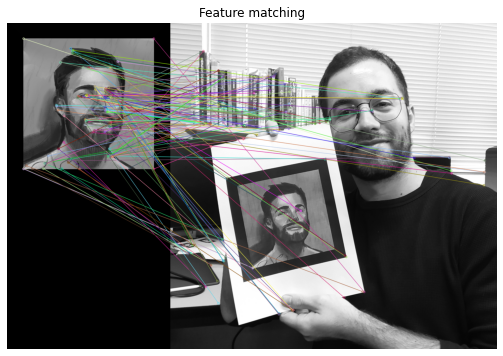

In [71]:
MIN_MATCHES = 30
            
# create brute force  matcher object
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Compute model keypoints and its descriptors
ref_image_pts, ref_image_dsc = orb.detectAndCompute(ref_image, None)

# Compute scene keypoints and its descriptors
src_image_pts, src_image_dsc = orb.detectAndCompute(src_image, None)

# Match frame descriptors with model descriptors
matches = bf_matcher.match(ref_image_dsc, src_image_dsc)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

if len(matches) > MIN_MATCHES:
    # Draw matches
    matches_img = cv2.drawMatches(ref_image, ref_image_pts, src_image, src_image_pts,
                          matches, 0, flags=2)
    # show result
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(matches_img, cmap='gray')
    plt.title('Feature matching')
    plt.show()
    
else:
    print("Not enough matches have been found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

# Homography

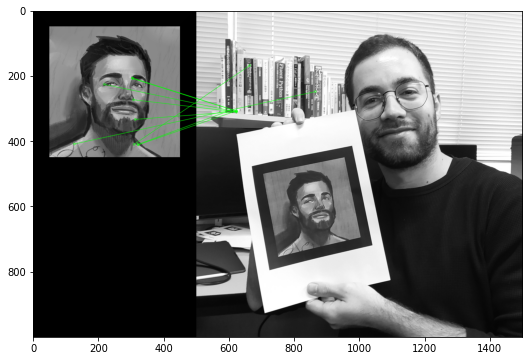

In [72]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    homography_src_pts = np.float32([ref_image_pts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    homography_dst_pts = np.float32([src_image_pts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, mask = cv2.findHomography(homography_src_pts, homography_dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = ref_image.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    src_image_marker = cv2.polylines(src_image, [np.int32(transformedCorners)], True,
                                      255, 5, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(matches), MIN_MATCHES))
    matches_mask = None

# Draw the matches
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None,
                      matchesMask=matches_mask, flags=2)
result = cv2.drawMatches(ref_image, ref_image_pts, src_image_marker,
                         src_image_pts, matches, None, **drawParameters)

# Show image
plt.figure(figsize=(12, 6))
plt.imshow(result, cmap='gray')
plt.show()

## Rendering the 3D model

Load the model

In [73]:
from ar_app.objloader_simple import OBJ

# Camera parameters
camera_parameters = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]])

# Load 3D model from OBJ file
obj = OBJ('./models/fox/fox.obj', swapyz=True)

Calculate the projection matrix

In [74]:
def projection_matrix(camera_parameters, homography):
    
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    
    return np.dot(camera_parameters, projection)

Render the model

In [75]:
# project cube or model
SCALE = 2  # Default 6
def render(img, obj, projection, model, color=False):

    vertices = obj.vertices
    scale_matrix = np.eye(3) * SCALE
    h, w = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        # render model in the middle of the reference surface. To do so,
        # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)

        cv2.fillConvexPoly(img, imgpts, (80, 27, 211))
    return img

Apply everything to render the model with applied homography

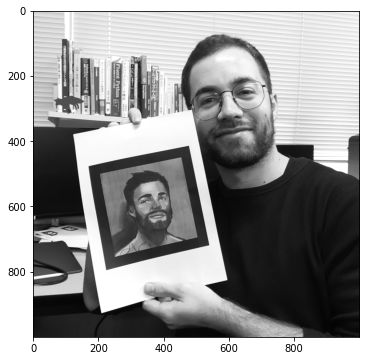

In [76]:
# Draw a polygon on the second image joining the transformed corners
render_image = np.copy(src_image)
frame = cv2.polylines(render_image, [np.int32(transformedCorners)], True, 255, 3, cv2.LINE_AA)

# obtain 3D projection matrix from homography matrix and camera parameters
projection = projection_matrix(camera_parameters, homography)  

# project cube or model
frame = render(frame, obj, projection, ref_image, False)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(frame, cmap="gray")
plt.show()